# Task:

Process sales data in an online store. The store management has decided to sell some goods on a special offer
The terms of this offer:
- delivery of orders with goods on special offer is free of charge
- the cost of delivery of all other orders is 20 UAH
- if the product does not fit the special offer, it can be returned free of charge (and only it!)

Data. Each line in the file is one order for a customer of the store:
- total: total order value  
- return: whether the product was returned by item (True = returned)
- special_proposition: the cost of the item from the item.  

The store's management realizes that some customers use special offers for free delivery of other goods. We are given the task to build analytics and roughly estimate the volume of dishonest actions of some customers.

# Solution:

In [1]:
import pandas as pd
data = pd.read_csv("data.csv")
data.head(4)

,Unnamed: 0,total,return,special_proposition
0,0,88.678970,False,9.141027
1,1,104.085105,True,8.569498
2,2,136.883561,False,50.300859
3,3,122.467426,False,44.532713


### Notation
$1\leq i \leq n$  
$\xi_i + \eta_i$ - the total cost of the order (total)  
$\eta_i$ - the cost of goods with special offer (special_proposition)  
$\xi_i$ - the cost of other goods (without special offer) 
$p_i$ - whether the item with the special offer was returned (return)

### 1. Return volumes
In this part of the work, we are interested in the probability that the user will return the product:
1. Let's estimate the probability of returning an item with s.o. $p$
2. For this probability $p$, let's build confidence intervals with levels of 95% and 99%

In [2]:
n = data.shape[0]
p = data['return'].sum() / n
print(f"{p=}")

p=0.278


In [3]:
# 2
from scipy import stats

for level in [0.95, 0.99, 1.00]:
    print(f"{level=}")
    alpha = 1 - level
    z = stats.norm.ppf(1 - alpha / 2 )
    p_left = p - z * ((p*(1-p))/n)**0.5
    p_right = p + z * ((p*(1-p))/n)**0.5
    confidents_interval = [p_left, p_right]
    print(f"{confidents_interval=}")



level=0.95
confidents_interval=[0.2502323524825303, 0.30576764751746977]
level=0.99
confidents_interval=[0.24150712526847778, 0.31449287473152227]
level=1.0
confidents_interval=[-inf, inf]


### 2. Cost of goods with s.o.
In this section, we are interested in analyzing the price of goods with s.o.:
1. Let's estimate the average cost of goods with s.o. $\mu$
2. Let's build confidence intervals with levels of 95% and 99% for the average cost of goods with s.o. $\mu$

In [4]:
mu_hat = data['special_proposition'].sum() / data['special_proposition'].shape[0]
print(f"{mu_hat=}")

from scipy import stats

for level in [0.95, 0.99]:
    print(f"{level=}")
    alpha = 1 - level
    z = stats.norm.ppf(1 - alpha / 2 )
    p_left = mu_hat - z * ((p*(1-p))/n)**0.5
    p_right = mu_hat + z * ((p*(1-p))/n)**0.5
    confidents_interval = [p_left, p_right]
    print(f"{confidents_interval=}")

mu_hat=31.323301306322005
level=0.95
confidents_interval=[31.295533658804537, 31.351068953839473]
level=0.99
confidents_interval=[31.286808431590483, 31.359794181053527]


Suppose that the cost of goods with s.o. ($\eta_i$) has the distribution $Exp(\lambda k)$, k>0, $\lambda$>0  
1. Draw a histogram and an emirical distribution function for the price of goods with s.o.
2. For the empirical distribution function, construct a confidence interval 
3. Estimate the parameter $\lambda k$ of the distribution
3. Let's construct a theoretical distribution function, in which we substitute the estimate of $\lambda k$

3. $Exp(\lambda k), \theta = \lambda k$ \
$\frac{1}{\hat\theta} = \frac{1}{N}   \sum_{i=1}^N X_i$ \
\
$\hat\theta = \dfrac {1}{\frac{1}{N}   \sum_{i=1}^N X_i}  $

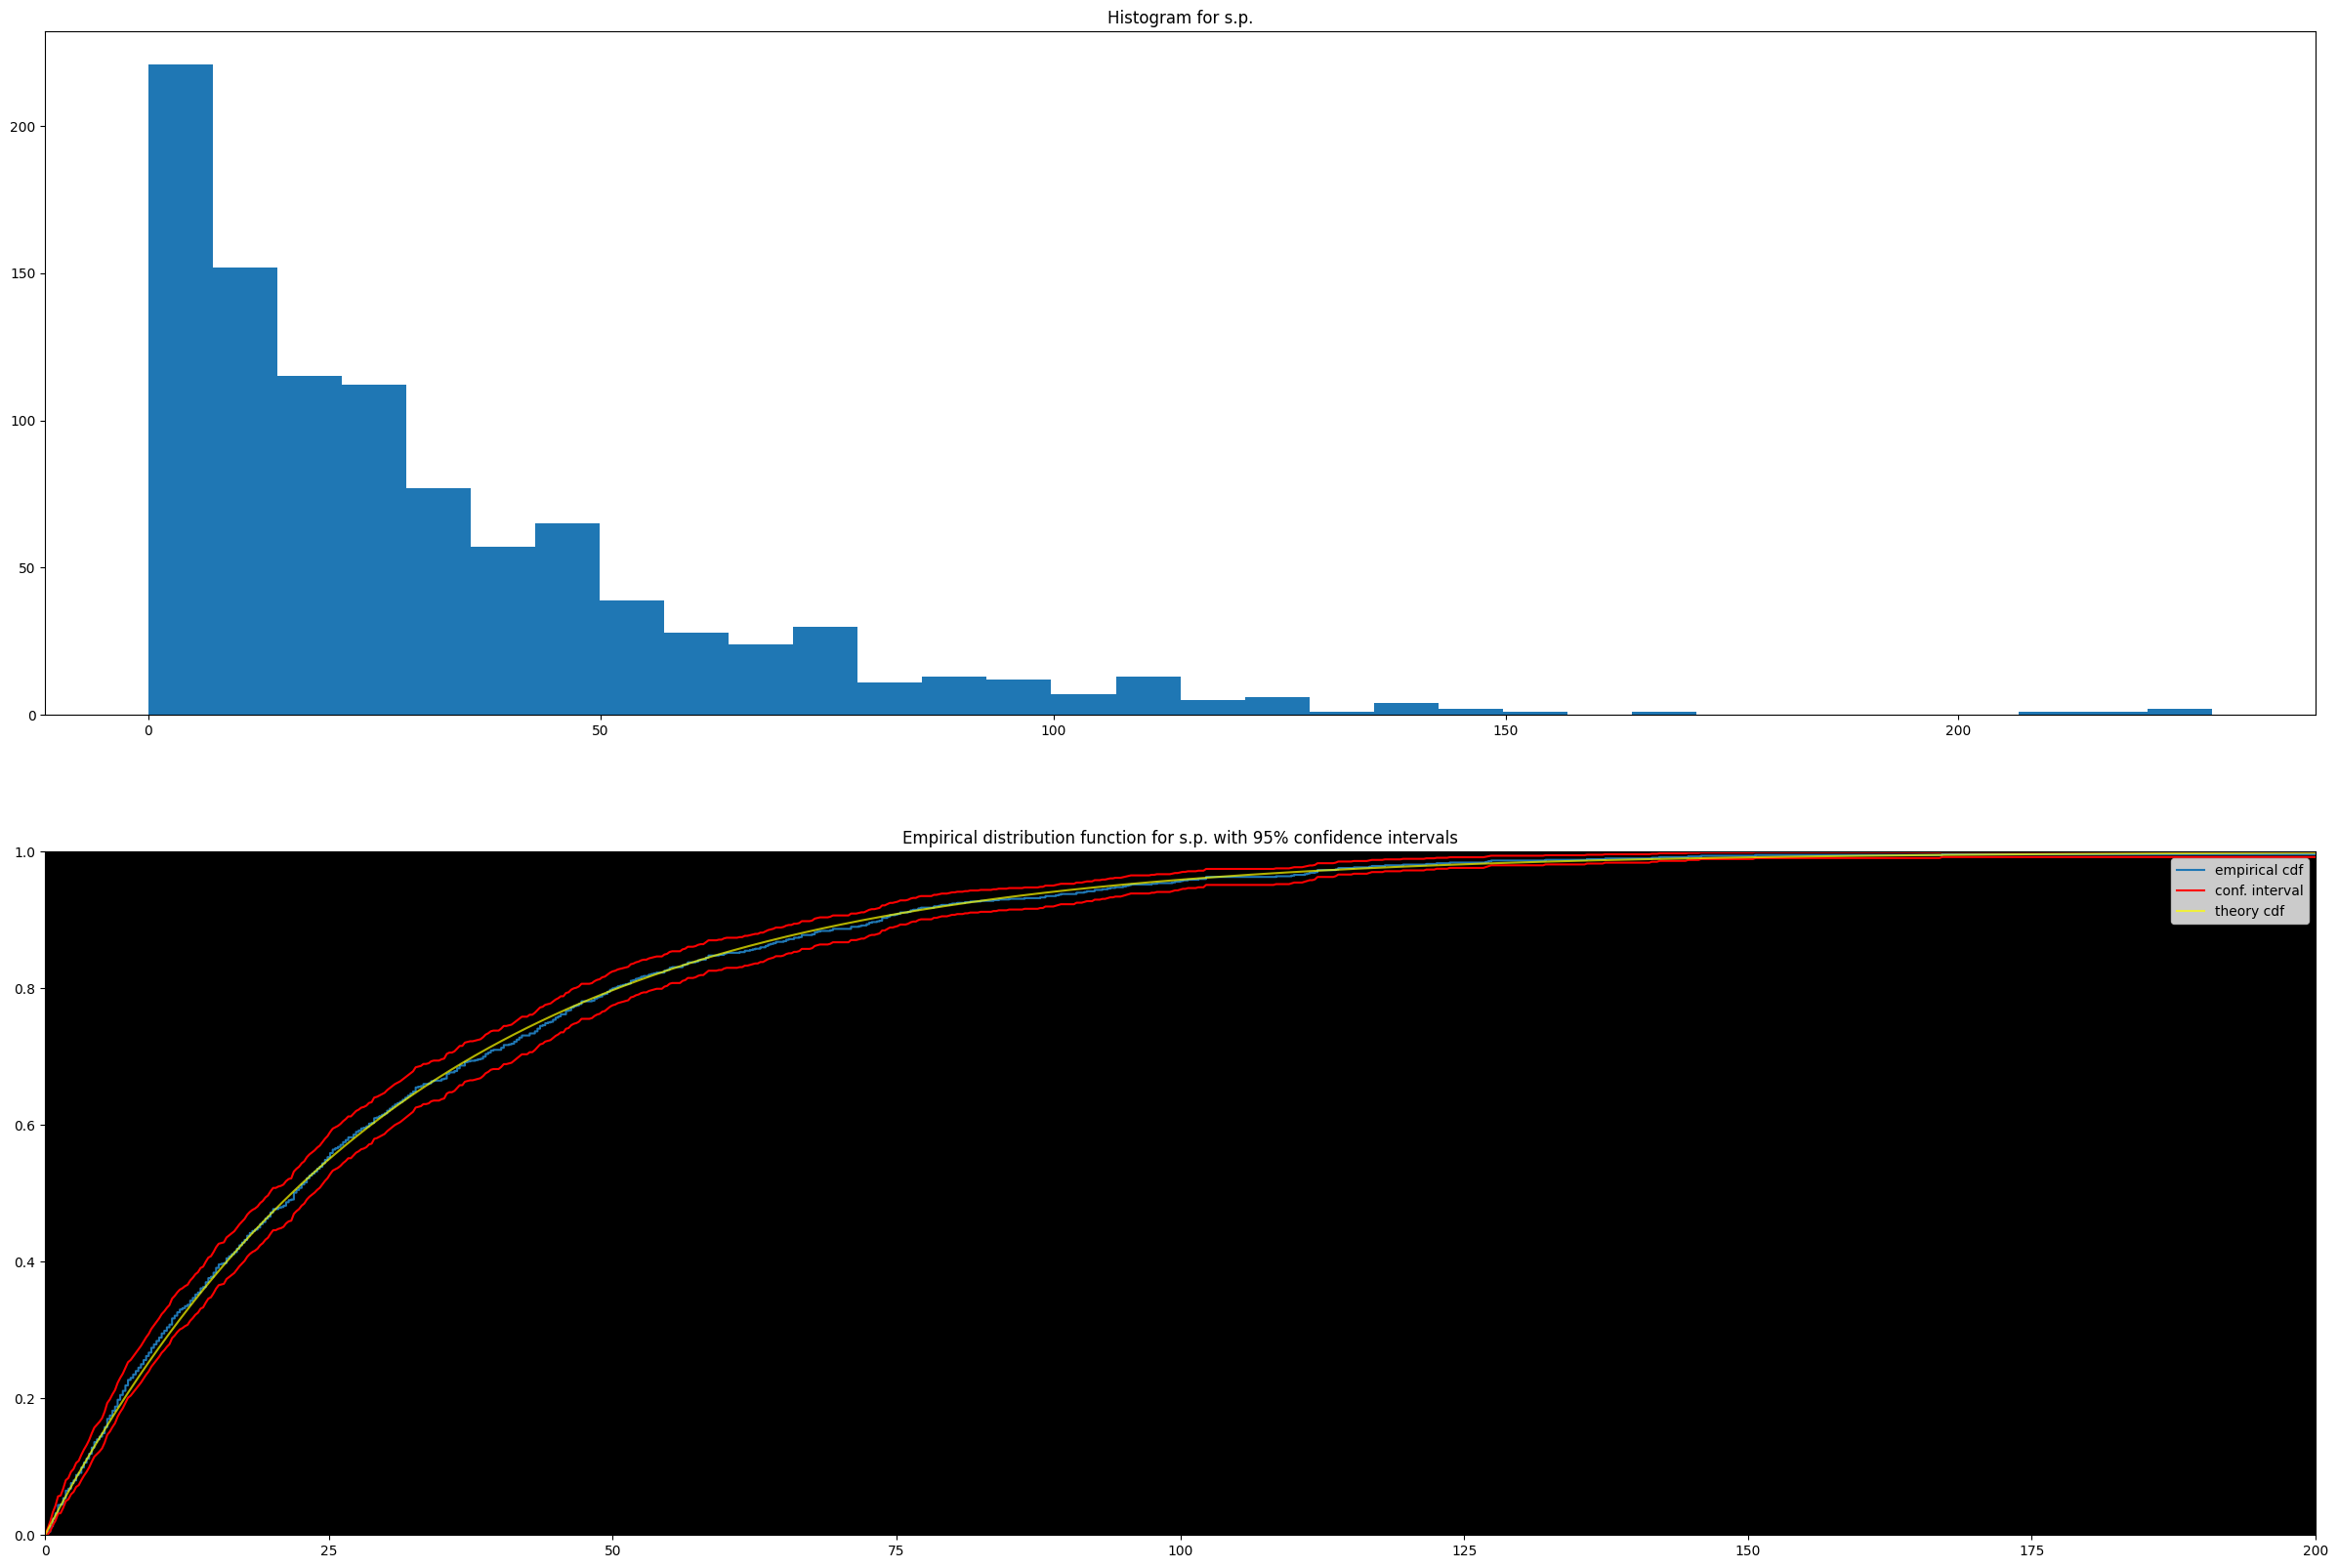

In [5]:
#1
import matplotlib.pyplot as plt
import numpy as np

def edf (data, t):
    return (data < t).mean()

sp_data =data['special_proposition']
n = sp_data.shape[0]
fig, axes = plt.subplots(2, 1, figsize=(30, 20))
axes[1].set_facecolor('black')

axes[0].hist(sp_data, bins='auto')
axes[0].set_title("Histogram for s.p.")
x = np.linspace(sp_data.min(), sp_data.max(), n)
axes[1].plot(x, [edf(sp_data, t) for t in x], drawstyle='steps-post', label='empirical cdf')
axes[1].set_title("Empirical distribution function for s.p. with 95% confidence intervals")

#2
def conf_int_left (data, t):
    f_hat = edf(data,t)
    return f_hat - (1.96)/n**0.5 * (f_hat*(1-f_hat))**0.5

def conf_int_right (data, t):
    f_hat = edf(data,t)
    return f_hat + (1.96)/n**0.5 * (f_hat*(1-f_hat))**0.5

axes[1].plot(x, [conf_int_left(sp_data, t) for t in x], color='red')
axes[1].plot(x, [conf_int_right(sp_data, t) for t in x], color='red', label='conf. interval')

# 3
theta_hat = 1/sp_data.mean()
axes[1].plot(x, [1-np.exp(-theta_hat*t) for t in x], color='yellow', alpha=0.7, label='theory cdf')
axes[1].legend()
axes[1].set_xlim(0, 200)
axes[1].set_ylim(0,1)
plt.show()


### 3. Other goods
Here we are interested in other goods (without s.o.) and the distribution of their values.
Here $\xi_i$=$total - special\_proposition$

1. Estimate the average cost of the product without s.o. $\mu$.
2. Construct confidence intervals with 95% and 99% levels for the average cost of the product without the special offer $\mu$.

Suppose that the value of other goods ($\xi_i$) has the distribution $Exp(\lambda)$, $\lambda$>0  
Here we assume that $\lambda$ here and in paragraph 2 is the same parameter, i.e.  
($\eta_i$) has the distribution $Exp(\lambda k)$,  
($\xi_i$) has the distribution $Exp(\lambda)$,  
 k>0, $\lambda$>0  
 
1. Draw a histogram and an emirical distribution function for the price of other goods.
2. For the empirical distribution function, plot the confidence interval 
3. Estimate the parameter $\lambda$ of the distribution. Is the estimate unbiased? Is it consistent?
4. Construct a theoretical distribution function to fit the estimate of $\lambda$.

In [6]:
data['other'] = data['total'] - data['special_proposition']
mu = data['other'].sum() / data.shape[0]
print("1. estimation of the average cost of goods without s.p. mu = " + str(mu))
print("2. confidence intervals for mu:")
for level in [0.95, 0.99]:
    print(f"{level=}")
    alpha = 1 - level
    z = stats.norm.ppf(1 - alpha / 2 )
    p_left = mu - z * ((p*(1-p))/n)**0.5
    p_right = mu + z * ((p*(1-p))/n)**0.5
    confidents_interval = [p_left, p_right]
    print(f"{confidents_interval=}")

1. estimation of the average cost of goods without s.p. mu = 99.16654696676925
2. confidence intervals for mu:
level=0.95
confidents_interval=[99.13877931925178, 99.19431461428671]
level=0.99
confidents_interval=[99.13005409203772, 99.20303984150077]


$Exp(\lambda)$ \
$\frac{1}{\hat\lambda} = \frac{1}{N} \sum_{i=1}^N X_i$ \
\
$\hat\lambda = \frac {1}{\frac{1}{N} \sum_{i=1}^N X_i} $
\
Checking for unbiased estimation: \
$ E[\hat\lambda ] = E[\frac {1}{\frac{1}{N} \sum_{i=1}^N X_i}] = | let \sum_{i=1}^N X_i = Y| $\
$ = N * E[Y^{-1}] = $ \
since the exponential distribution is a case of the gamma distribution $(X_i = Gamma(1;{\frac{1}{\lambda}}))$ \
then $Y_i - Gamma(N;{\frac{1}{\lambda}})$ \
$=N \int_{0}^{\infty} y^{-1} \frac{1}{Г(N)} y^{N-1} \lambda^{N} e^{-\lambda y } \, dy = \frac{N\lambda^{N}}{Г(N)} \frac{Г(N-1)}{\lambda^{N-1}} = \frac{N}{N -1} \lambda \neq \lambda $ \
$ \Rightarrow \hat\lambda$ shifted \
\
Consistency: \
By LLN $\frac{1}{N}\sum_{i=1}^N X_i \xrightarrow{\hspace{2pt}\stackrel{p}{}} \lambda $\
So, $ \frac{1}{\frac{1}{N}\sum_{i=1}^N X_i} \xrightarrow{\hspace{2pt}\stackrel{p}{}} \lambda $
 
$ \Rightarrow \hat\lambda$ is consistent

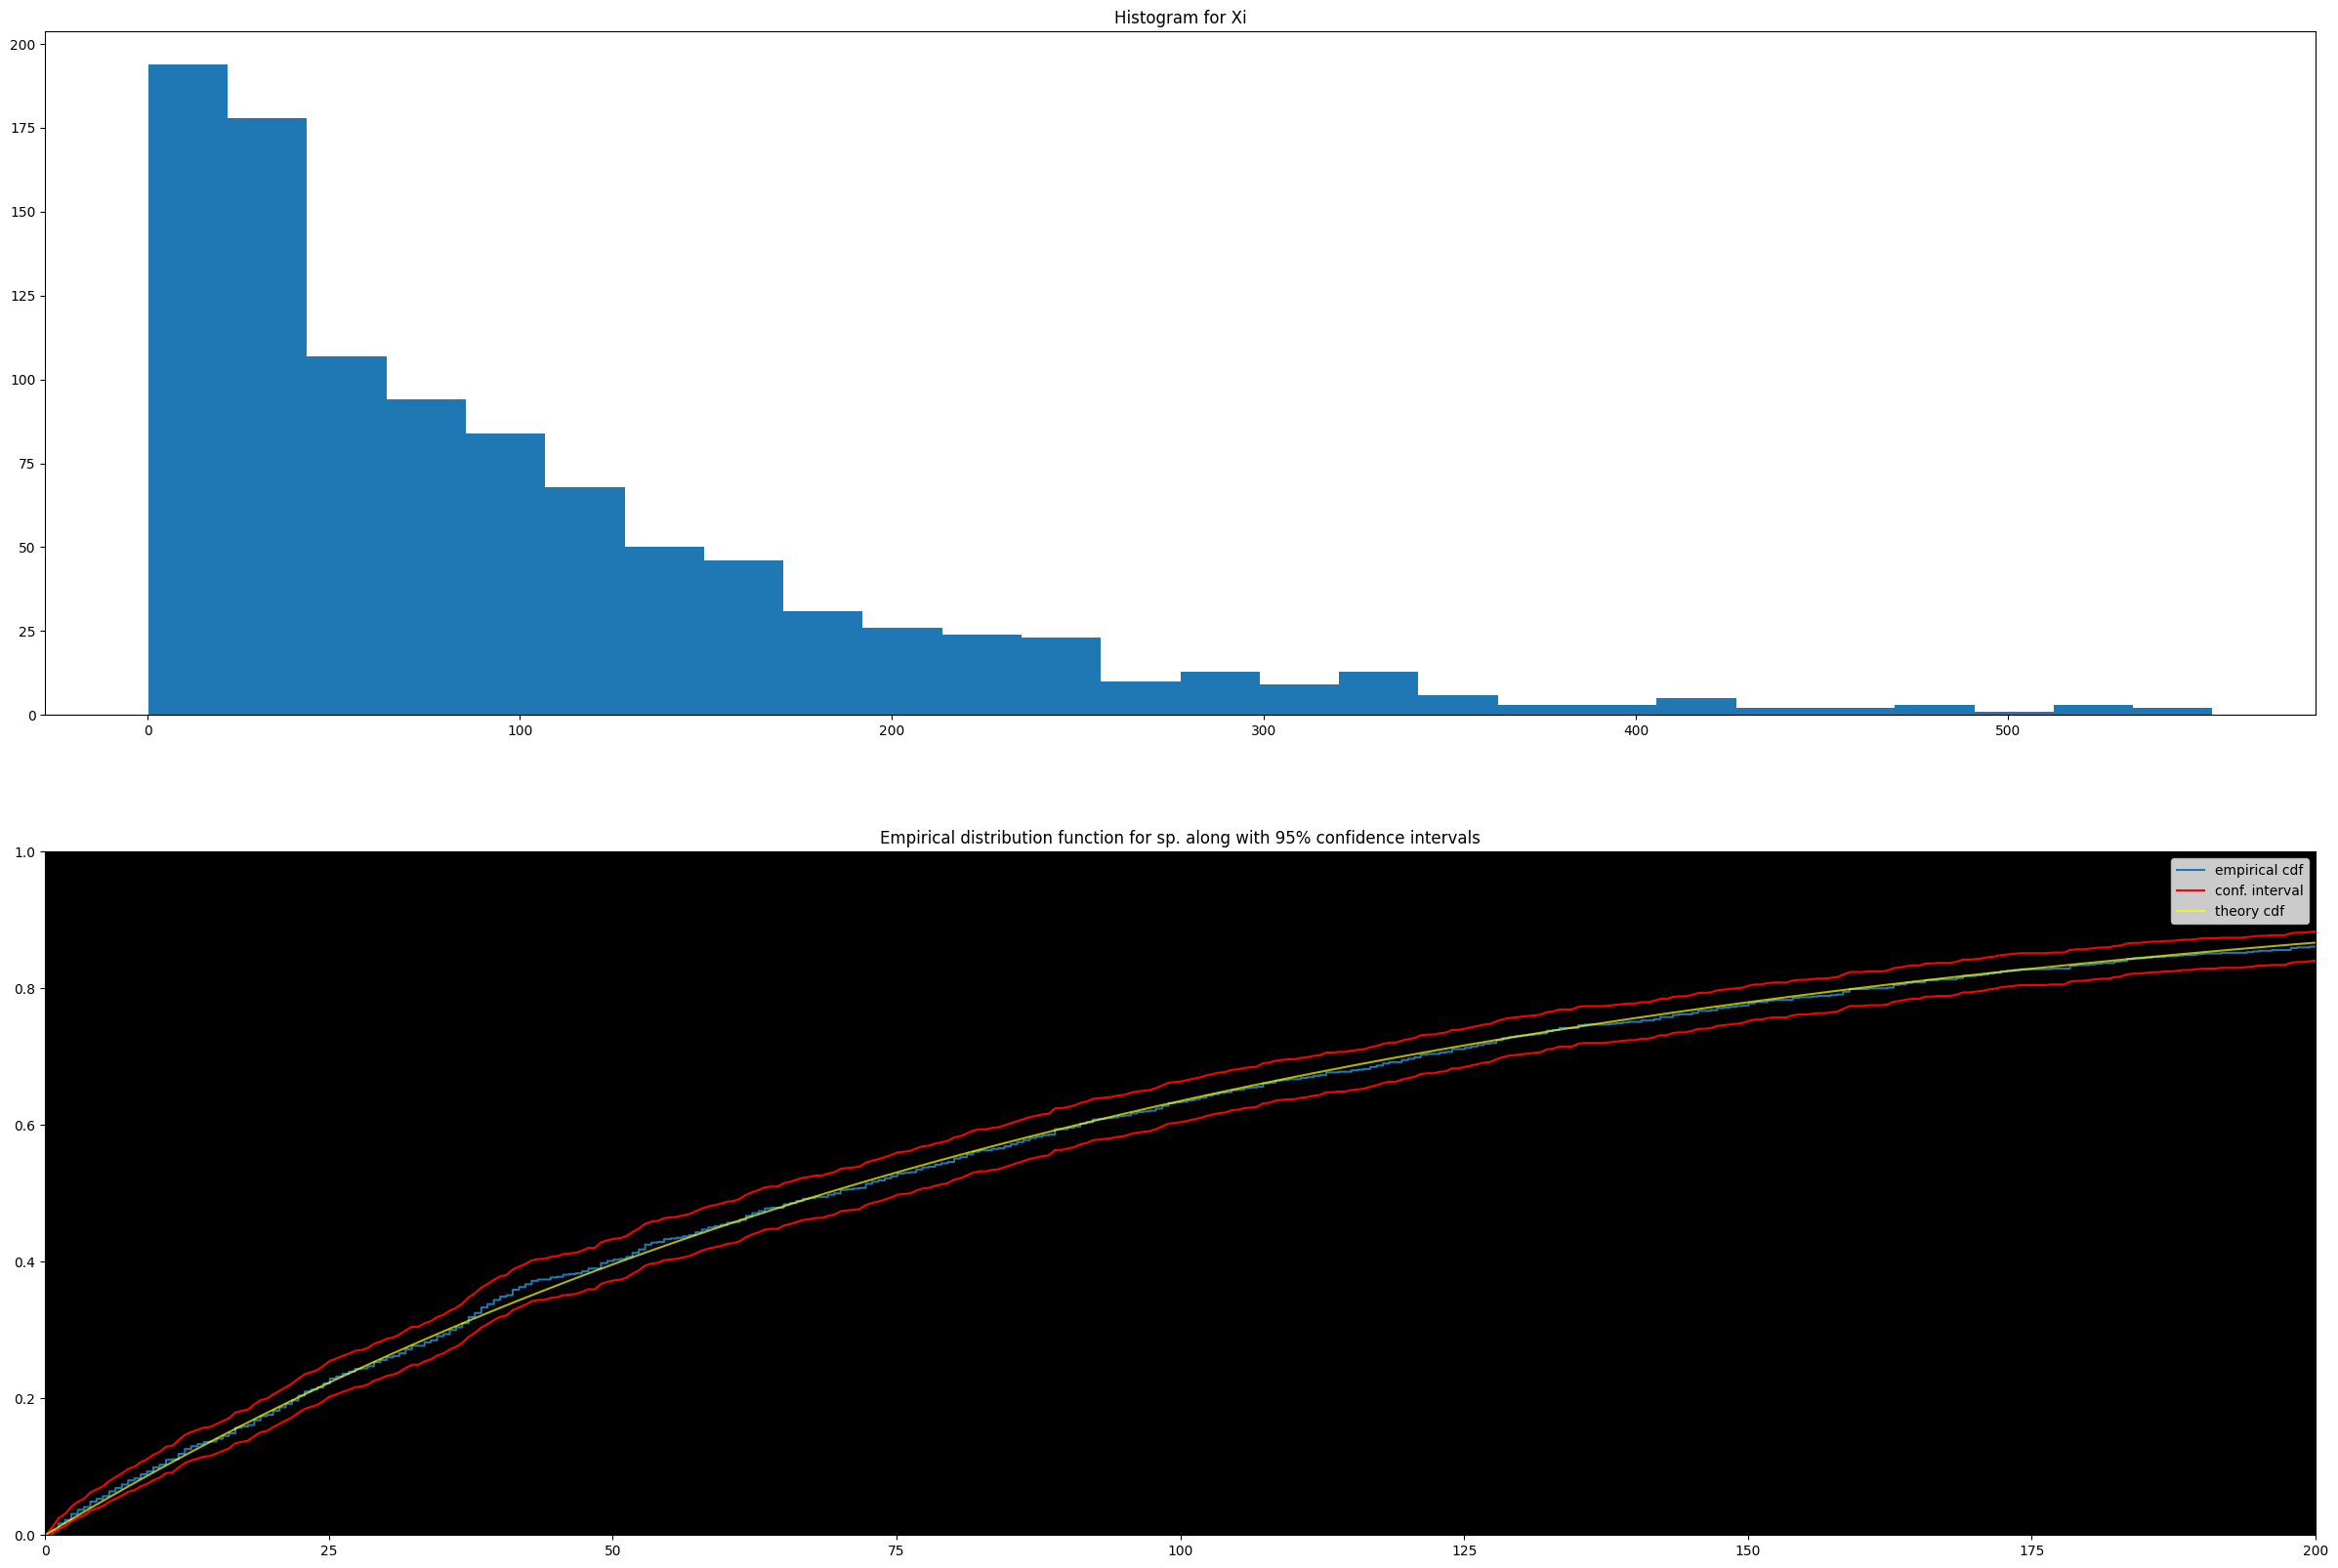

In [7]:
xi_data = data['other']
n = xi_data.shape[0]
fig, axes = plt.subplots(2, 1, figsize=(30, 20))
axes[1].set_facecolor('black')

axes[0].hist(xi_data, bins='auto')
axes[0].set_title("Histogram for Xi")
x = np.linspace(xi_data.min(), xi_data.max(), n)
axes[1].plot(x, [edf(xi_data, t) for t in x], drawstyle='steps-post', label='empirical cdf')
axes[1].set_title("Empirical distribution function for sp. along with 95% confidence intervals")
axes[1].plot(x, [conf_int_left(xi_data, t) for t in x], color='red')
axes[1].plot(x, [conf_int_right(xi_data, t) for t in x], color='red', label='conf. interval')

lambda_hat = 1/xi_data.mean()
axes[1].plot(x, [1-np.exp(-lambda_hat*t) for t in x], color='yellow', alpha=0.7, label='theory cdf')
axes[1].set_xlim(0, 200)
axes[1].set_ylim(0,1)
axes[1].legend()
plt.show()

### 4. The fate of s.p. in ordered

In this section, we are interested in the share of goods from s.p. in the order. That is, the values of $\frac{\eta_i}{\xi_i+\eta_i}$. Maybe they have something to do with returns

1. Assuming that ($\eta_i$) has the distribution $Exp(\lambda k)$, and ($\xi_i$) has the distribution $Exp(\lambda)$, find the distribution $\frac{\eta_i}{ \xi_i+\eta_i}$
2. Are the graphs of the theoretical distribution and the empirical distribution function similar?
3. Are the scatter plots of pairs (scatterplot) for $\frac{\eta_i}{\xi_i+\eta_i}$ and $p_i$ (return) related?
4. Is it possible to estimate the parameters $\lambda$ and $k$ only from the sample $\frac{\eta_i}{\xi_i+\eta_i}$?
5. Is it possible to estimate the parameters $\lambda$ and $k$ only from the sample $\frac{\xi_i}{\xi_i+\eta_i}$?
6. Is it possible to estimate the parameters $\lambda$ and $k$ only from the sample $\frac{\xi_i}{\eta_i}$?

### Solution:
1. $ \eta_i = Exp(\lambda k), \xi_i =Exp(\lambda) $ \
$ \eta_i , \xi_i $ - independent \
Since we want to get the distribution $\dfrac{\eta_i}{\xi_i + \eta_i}$ , we simplify to the form $\dfrac{1}{\frac{\xi_i}{\eta_i} + 1}$ \
Then we first find the distribution of the share: \
\
$ P(\frac{\xi_i}{\eta_i} < t) = P(\xi_i < t\eta_i) = \int_{0}^{\infty} P(\xi_i < ty) f_\eta (y) dy = \int_{0}^{\infty} (1-e^{-\lambda ky}) \lambda k e^{-\lambda k y} dy = \lambda k (\int_{0}^{\infty} e^{-\lambda k y} dy-\int_{0}^{\infty} e^{-\lambda k y -\lambda t y} dy) = \lambda k ( \frac{1}{\lambda k} - \int_{0}^{\infty} e^{(-\lambda k -\lambda t) y} dy) = \frac{\lambda k}{\lambda k} - \frac{\lambda k}{\ lambda (k+t)} = 1 - \frac {k}{k+t} = \frac {t}{k+t} $ \
\
Then $ F_1(t) = P(\frac{\xi}{\eta}<t>), P(\frac{\eta}{\eta + \xi}<t)=P(\frac{1} {1+\frac{\xi}{\eta}}<t) = P(1 + \frac{\xi}{\eta} > \frac {1}{t}) = P(\frac{\xi }{\eta}>\frac{1}{t}-1) = 1 - P(\frac{\xi}{\eta}<\frac{1}{t}-1) = 1 - F_1(\ frac{1}{t}-1)$\
$ F(t) = 1 - \dfrac{\frac{1}{t}-1}{k+\frac{1}{t}-1}=\dfrac{k}{k+\frac{1}{t }-1}$
2. From the graphs below, we conclude that the graphs of the theoretical distribution and the empirical distribution function are similar.
3. Also, from the scatter diagram of pairs for $\frac{\eta_i}{\xi_i+\eta_i}$ and $p_i$ (return), we can say that they are clearly related: there is a threshold value at which people start returning goods.
4. From the distribution function for $\frac{\eta_i}{\xi_i+\eta_i}: F(t) = \dfrac{k}{k+\frac{1}{t}-1}$ it follows that we can estimate $k$ , but we cannot estimate $\lambda$
5. Let's construct the distribution function for $\frac{\xi_i}{\xi_i+\eta_i}: P(\frac{\xi_i}{\xi_i+\eta_i}<t) = P(1-\frac{\eta_i}{\ xi_i+\eta_i}<t) = P(\frac{\eta_i}{\xi_i+\eta_i}<1-t)=F(1-t)=\dfrac{k}{k+\frac{1}{1- t}-1}$ \
So it also follows that we can estimate $k$ , but we cannot estimate $\lambda$
6. Since the distribution for $\frac{\xi_i}{\eta_i}: P(\frac{\xi_i}{\eta_i} < t) = \dfrac {t}{k+t}$, then again it follows that we can estimate $k$ , but we cannot estimate $\lambda$

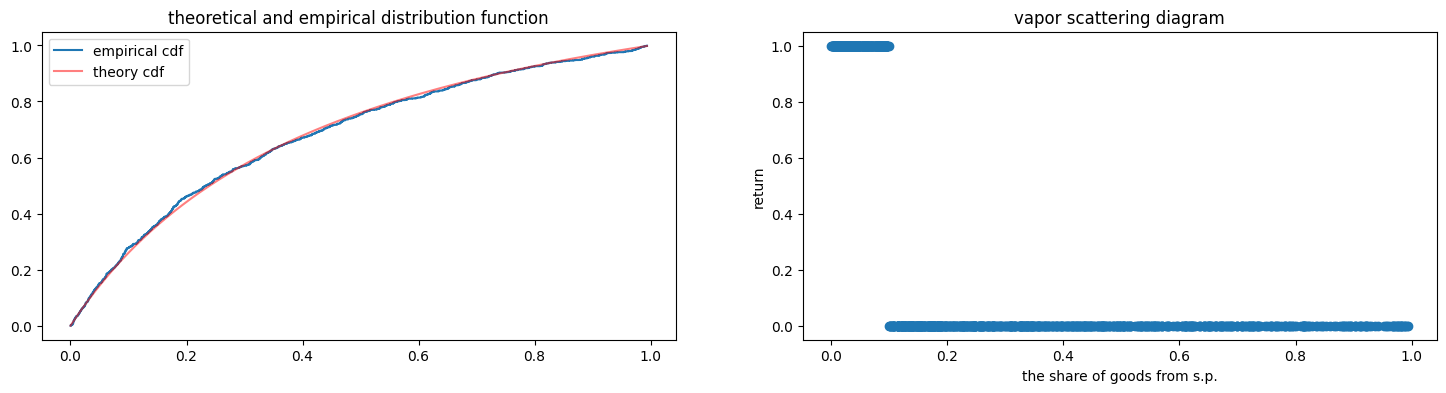

In [8]:
portion_data = data['special_proposition'] / data['total']

def F(t):
    lambda_hat = 1/xi_data.mean()
    lambdak_hat = 1/sp_data.mean()
    k_hat = lambdak_hat/lambda_hat
    k = k_hat
    result = k / (k + 1/t -1)
    return result
    
n = portion_data.shape[0]
fig, ax = plt.subplots(1, 2, figsize=(18, 4))
# axes[1].set_facecolor('black')

ax[0].set_title("theoretical and empirical distribution function")
x = np.linspace(portion_data.min(), portion_data.max(), n)
ax[0].plot(x, [edf(portion_data, t) for t in x], drawstyle='steps-post', label='empirical cdf')
ax[0].plot(x, F(x), color='red', label="theory cdf", alpha=0.5)
ax[0].legend()

ax[1].set_title("vapor scattering diagram")
ax[1].scatter(portion_data, data['return'])
ax[1].set_xlabel('the share of goods from s.p.')
ax[1].set_ylabel('return')
_ = 1


### 5. Share of the value of the s.p., at which the return was made
From the graph, we can see that there is a certain threshold value at which people start returning goods.\
Let's take as a critical value the average between the maximum among the goods that were returned and the minimum among the goods from the s.p. that were not returned

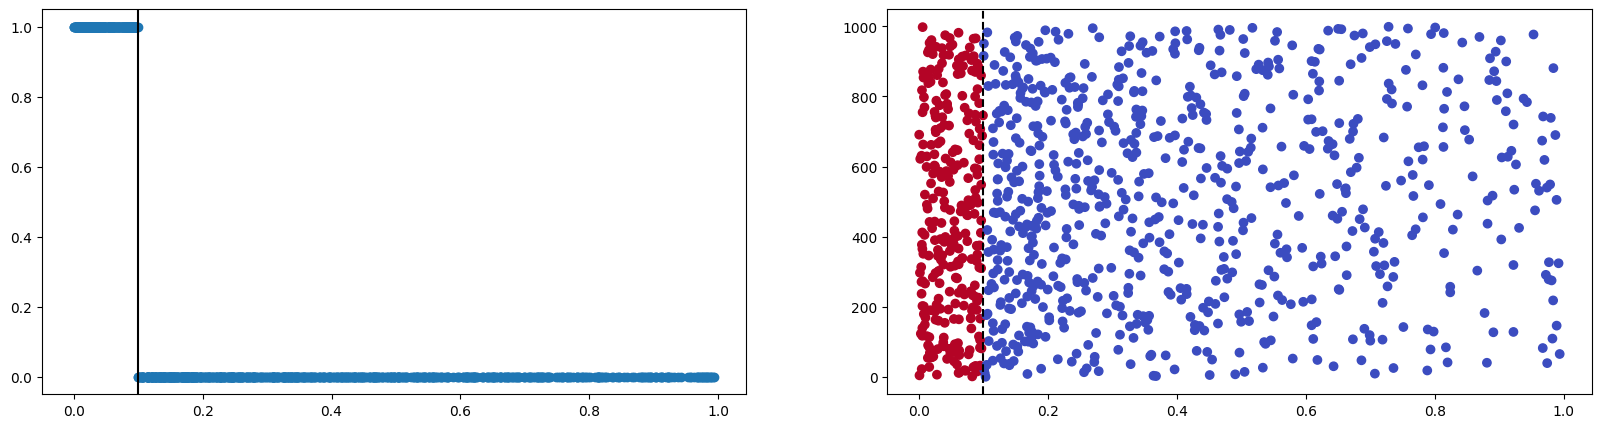

In [9]:
data['portion'] = data['special_proposition'] / data['total']
max_returned = data.loc[data['return']==True, 'portion'].max()
min_not_returned = data.loc[data['return']==False, 'portion'].min()
estimation = (max_returned + min_not_returned) / 2

fig, ax = plt.subplots(1,2,figsize=(20,5))
ax[0].scatter(portion_data, data['return'])
ax[0].axvline(x=estimation, color='black')

ax[1].scatter(portion_data, range(len(portion_data)), c=data['return'], cmap='coolwarm')
ax[1].axvline(x=estimation, color='black', linestyle='--')


### 6. Finances

We are interested in the analysis of profit (or loss) due to free delivery of goods

We believe that
- delivery cost UAH 20 (both ways)
- total = original cost + 20% of original cost
- special_proposition = original cost + 20% of original cost

We consider only the cases when the goods with s.p. was returned

We will calculate the profit as follows: PROFIT = INCOME - COSTS

INCOME = Total amount of money for 'other' goods, as money for goods from s.p. we returned The product from s.p. stayed with us.

To calculate COSTS, we consider that the price of the product at which we sell is 1.2 times higher than the original cost of the product (purchase price). So original_price = our_price / 1.2 \
Then, COST = original_price for 'other' items + shipping costs

Also, let's count how many times the profit will increase only in relation to the cases when the goods from the s.p. was returned, not among all sales.

In [10]:
#1 
amount_of_returned = data[data['return']==True].shape[0]
total_delivery_costs = 20 * amount_of_returned
print("Total delivery costs for cases when goods from returned:", total_delivery_costs)

#2
data_return_sum = data[data['return']==True].sum()

income = data_return_sum['other']
costs = data_return_sum['other']/1.2 + total_delivery_costs
profit = income - costs
print("Profit, when the goods from s.p. was returned:", round(profit,2))

#3
new_income = data_return_sum['other']
new_costs = data_return_sum['other']/1.2
new_profit = new_income - new_costs
growth = new_profit/profit
print("New profit, when the goods from the s.p. was returned:", round(new_profit,2))
print(f"Under such conditions, the profit will increase by {round(growth,2)} times for goods with s.p. that were returned.")

Total delivery costs for cases when goods from returned: 5560
Profit, when the goods from s.p. was returned: 2154.8
New profit, when the goods from the s.p. was returned: 7714.8
Under such conditions, the profit will increase by 3.58 times for goods with s.p. that were returned.
